In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,AveragePooling2D, Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
import itertools

In [2]:
os.getcwd()
os.chdir('dataset/Face-Mask-Dataset')
os.getcwd()

'H:\\Mask Detection - FYP\\face-mask-detection-covid19\\dataset\\Face-Mask-Dataset'

In [5]:
INIT_LR = 1e-3
EPOCHS = 20
BS = 32

directory_train = os.getcwd()+r"\Train"
directory_valid = os.getcwd()+r"\Validation"
categories = ["WithMask", "WithoutMask"]

#Grabbing the dataset to train the model from the directory and converting it to numpy array, preprocessing it using mobilenetV2
# preprocessing and categorize the images.
print("[INFO] loading images...")

train_data = []
train_labels = []
valid_data = []
valid_labels = []
for category in categories:
    path = os.path.join(directory_train, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	train_data.append(image)
    	train_labels.append(category)

# One-Hot Encoding to get 0s and 1s.
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
train_labels = to_categorical(train_labels)

train_data = np.array(train_data, dtype="float32")
train_labels = np.array(train_labels)

#Doing the same for validation set now.
for category in categories:
    path = os.path.join(directory_valid, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	valid_data.append(image)
    	valid_labels.append(category)
        
# One-Hot Encoding to get 0s and 1s.
lb = LabelBinarizer()
valid_labels = lb.fit_transform(valid_labels)
valid_labels = to_categorical(valid_labels)

valid_data = np.array(valid_data, dtype="float32")
valid_labels = np.array(valid_labels)

os.chdir('..//..//')

# (trainX, testX, trainY, testY) = train_test_split(data, labels,
# 	test_size=0.20, stratify=labels, random_state=42)

[INFO] loading images...


array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]])

In [6]:
train_data, train_labels = shuffle(train_data,train_labels)
valid_data, valid_labels = shuffle(valid_data,valid_labels)

In [8]:
print("Training data shape: " + str(train_data.shape))
print("Validation data shape: " + str(valid_data.shape))
#train_data = np.save('train_data.npy',data)

Training data shape: (10000, 224, 224, 3)
Validation data shape: (800, 224, 224, 3)


## Creating a model 

In [10]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224,224,3))

# construct the head of the model that will be placed on top of the
# the base model
x = baseModel.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)

model = Model(inputs=baseModel.input, outputs=x)

for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=0.0001)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"])
model.summary()

[INFO] compiling model...
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________________________________

In [11]:
# Training the model
print("[INFO] training head...")
history = model.fit(
	aug.flow(train_data, train_labels, batch_size=BS),
	steps_per_epoch=len(train_data) // BS,
	validation_data=(valid_data, valid_labels),
	epochs=EPOCHS,
    batch_size=BS,
)


[INFO] training head...
Epoch 1/20
312/312 [==============================] - 374s 1s/step - loss: 0.1808 - accuracy: 0.9293 - val_loss: 0.0430 - val_accuracy: 0.9900
Epoch 2/20
312/312 [==============================] - 357s 1s/step - loss: 0.0716 - accuracy: 0.9768 - val_loss: 0.0325 - val_accuracy: 0.9925
Epoch 3/20
312/312 [==============================] - 338s 1s/step - loss: 0.0550 - accuracy: 0.9826 - val_loss: 0.0289 - val_accuracy: 0.9937
Epoch 4/20
312/312 [==============================] - 363s 1s/step - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0287 - val_accuracy: 0.9925
Epoch 5/20
312/312 [==============================] - 354s 1s/step - loss: 0.0356 - accuracy: 0.9879 - val_loss: 0.0296 - val_accuracy: 0.9900
Epoch 6/20
312/312 [==============================] - 351s 1s/step - loss: 0.0350 - accuracy: 0.9892 - val_loss: 0.0242 - val_accuracy: 0.9950
Epoch 7/20
312/312 [==============================] - 344s 1s/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.024

In [ ]:
if (not(os.path.exists(os.getcwd()+r'\models\mask-model-2.h5'))):
    model.save('mask-model-2.h5')

In [14]:
model.save('models/mask-model-2.1.h5')

In [16]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

## Plot of Loss and Accuracy

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

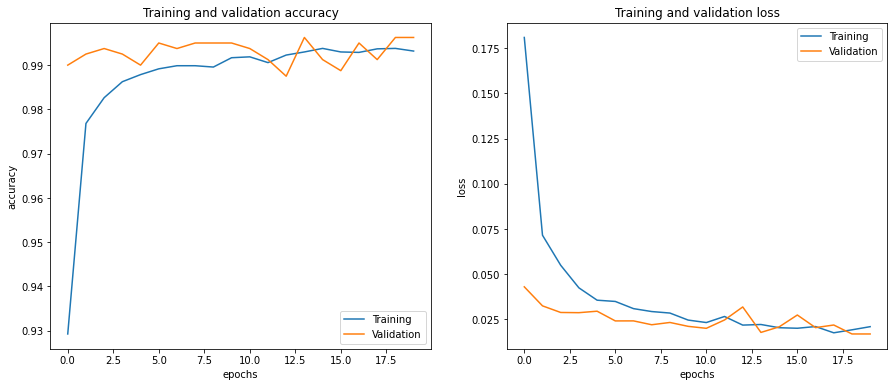

Accuracy::  0.993
Loss:  0.021
------------------------------
Validation accuracy:  0.996
Validation loss:  0.017


In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
print('Accuracy:: ', round(acc[-1],3))
print('Loss: ',round(loss[-1],3))
print('------------------------------')
print('Validation accuracy: ',round(val_acc[-1],3))
print('Validation loss: ',round(val_loss[-1],3))

## Testing of Model

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model(os.getcwd()+r'\models\mask-model-2.h5')

In [82]:
os.chdir('dataset/Face-Mask-Dataset')
directory_test = os.getcwd()+r"\Test"
categories = ["WithMask", "WithoutMask"]

#Grabbing the dataset to test the model from the directory and converting it to numpy array, preprocessing it using mobilenetV2
# preprocessing and categorize the images.
print("[INFO] loading test images...")

test_data = []
test_labels = []
for category in categories:
    path = os.path.join(directory_test, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	test_data.append(image)
    	test_labels.append(category)

# One-Hot Encoding to get 0s and 1s.
lb = LabelBinarizer()
test_labels = lb.fit_transform(test_labels)
test_labels = to_categorical(test_labels)

test_data = np.array(test_data, dtype="float32")
test_labels = np.array(test_labels)
os.chdir('..//..//')

[INFO] loading test images...


In [83]:
#loaded_model.evaluate(x=data,y=labels,batch_size=32)

## Evaluation Metrics

### In progress....

In [84]:
test_labels = np.argmax(test_labels,axis=1).astype('float32')
predict_labels = np.argmax(model.predict(test_data), axis=1).astype('float32')

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[479   4]
 [  0 509]]


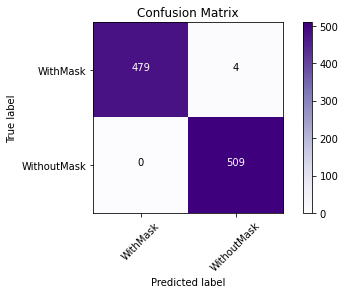

In [73]:
cm = confusion_matrix(y_true=test_labels, y_pred=predict_labels)
plt.figure()
plot_confusion_matrix(cm, classes=categories, title='Confusion Matrix')

In [85]:
print(classification_report(test_labels, predict_labels,target_names=lb.classes_))

              precision    recall  f1-score   support

    WithMask       1.00      0.99      1.00       483
 WithoutMask       0.99      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992

